In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [11]:
def global_to_boat(boat_heading, global_val):
    boat_x = global_val[0] * jnp.sin(boat_heading) + global_val[1] * jnp.cos(boat_heading)
    boat_y = global_val[1] * jnp.sin(boat_heading) - global_val[0] * jnp.cos(boat_heading)

    return jnp.array((boat_x.squeeze(), boat_y.squeeze()))

In [18]:
air_kinematic_viscosity = 0.0000171
air_density =  1.3
sail_area = 6.2 # [m^2]
sail_chord = 2  # [m]  # TODO sort these values out
sail_span = sail_area / sail_chord  # [m]
sail_aspect_ratio = sail_span / sail_chord

AWA = -90.0
TSA = 45.0
AOA = -45.0


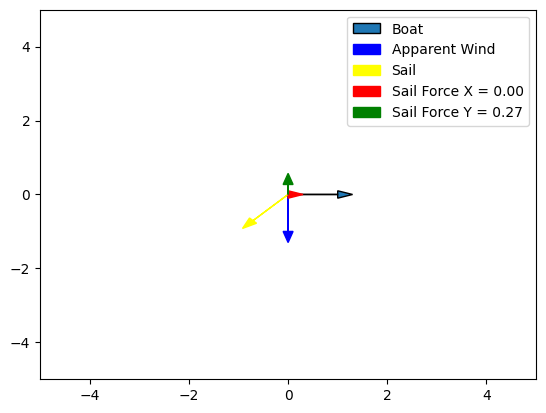

In [57]:
wind_dir = 180.0  # deg
wind_speed = 5.0  # in ms^-1
wind_vel = wind_speed * jnp.array((jnp.sin(jnp.radians(wind_dir)),
                                jnp.cos(jnp.radians(wind_dir))))

boat_dir = jnp.array((1.0, 0.0))
boat_vel = jnp.array((0.0,
                      0.0))
sail_angle = jnp.radians(45.0)
# boat_heading = jnp.radians(jnp.ones(()) * 315)
boat_heading = jnp.radians(jnp.ones(()) * 90)
# boat_heading = jnp.radians(jnp.ones(()) * 270)
transformed_wind = global_to_boat(boat_heading, wind_vel)
apparent_wind = transformed_wind - boat_vel
apparent_wind_angle = jnp.arctan2(apparent_wind[1], apparent_wind[0])
apparent_wind_speed = jnp.sqrt(apparent_wind[0] ** 2 + apparent_wind[1] ** 2)

print(f"AWA = {jnp.degrees(apparent_wind_angle)}")

true_sail_angle = jnp.copysign(sail_angle, -apparent_wind_angle)  # prevents sign of 0 when AWA == 0
# reversed_apparent_wind_angle = jnp.copysign((jnp.pi - jnp.abs(apparent_wind_angle)), apparent_wind_angle)  # TODO a way to ensure correct direction?
# aoa = reversed_apparent_wind_angle - true_sail_angle
aoa = apparent_wind_angle + true_sail_angle
print(f"TSA = {jnp.degrees(true_sail_angle)}")
print(f"AOA = {jnp.degrees(aoa)}")
# TODO check the above

# Calc sail force
aoa = jax.lax.select(aoa * true_sail_angle < 0, 0.0, aoa)
eff_aoa = aoa  # eff_aoa : effective angle of attack
eff_aoa = jnp.where(aoa < -jnp.pi / 2, jnp.pi + aoa, eff_aoa)
eff_aoa = jnp.where(aoa > jnp.pi / 2, -jnp.pi + aoa, eff_aoa)

pressure = 0.5 * air_density * apparent_wind_speed ** 2 * jnp.cos(jnp.cos(sail_angle))**2

aero_friction = jax.lax.select(apparent_wind_speed != 0,
                               3.55 / jnp.sqrt((apparent_wind_speed * sail_chord) / air_kinematic_viscosity),
                               0.0)

separation = 1 - jnp.exp(-((jnp.abs(eff_aoa)) / (jnp.pi / 180 * 25)) ** 2)

coeff_lift = 2 * jnp.pi * eff_aoa
coeff_drag = aero_friction + ((coeff_lift ** 2 * separation) / (jnp.pi * sail_aspect_ratio))

sail_lift = pressure * sail_area * coeff_lift
sail_drag = pressure * sail_area * coeff_drag

separated_force_x = jnp.sign(aoa) * pressure * sail_area * jnp.sin(aoa)**2 * jnp.sin(sail_angle)
separated_force_y = -jnp.sign(aoa) * pressure * sail_area * jnp.sin(aoa)**2 * jnp.cos(sail_angle)

sail_force_x = (1 - separation) * (sail_lift * jnp.sin(apparent_wind_angle) - sail_drag * jnp.cos(apparent_wind_angle)) + separation * separated_force_x
sail_force_y = (1 - separation) * (-sail_drag * jnp.sin(apparent_wind_angle) - sail_lift * jnp.cos(apparent_wind_angle)) + separation * separated_force_y

rotation_matrix = jnp.array([[jnp.cos(apparent_wind_angle), -jnp.sin(apparent_wind_angle)],
                             [jnp.sin(apparent_wind_angle), jnp.cos(apparent_wind_angle)]])
awa_vec = rotation_matrix.dot(boat_dir)

rotation_matrix = jnp.array([[jnp.cos(true_sail_angle), -jnp.sin(true_sail_angle)],
                             [jnp.sin(true_sail_angle), jnp.cos(true_sail_angle)]])
sail_vec = rotation_matrix.dot(boat_dir)

plt.arrow(0, 0, boat_dir[0], boat_dir[1], head_width=0.2, label="Boat")
plt.arrow(0, 0, awa_vec[0], awa_vec[1], head_width=0.2, color="Blue", label="Apparent Wind")
plt.arrow(0, 0, -sail_vec[0], -sail_vec[1], head_width=0.2, color="Yellow", label="Sail")
plt.arrow(0, 0, sail_force_x * jnp.sign(boat_dir[0]), 0, head_width=0.2, color="Red", label=f"Sail Force X = {sail_force_x:.2f}")
plt.arrow(0, 0, 0, sail_force_y, head_width=0.2, color="Green", label=f"Sail Force Y = {sail_force_y:.2f}")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.show()